# Motion Classifier for Accelerometer Data
The implemented neural network predicts the motion based on accelerometer data from an iOS phone.
The dataset consists of training samples made from x,y,z-accelerometer values as recorded by iOS and the associated motion type (idle, run, walk).
The here implemented and trained model is exported for use in iOS CoreML.

In [1]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import model_selection

import keras
from keras import layers

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Load and Inspect the Dataset

In [2]:
# load the dataset from private server
dataset = pd.read_csv('https://example.com/data.csv')
dataset.columns = ['type', 'x', 'y', 'z']
dataset.describe()

,type,x,y,z
count,8199.000000,8199.000000,8199.000000,8199.000000
mean,1.110989,-0.189114,-0.058911,-0.743541
std,0.782914,0.651654,0.505924,0.850336
min,0.000000,-3.463000,-2.243000,-5.505000
25%,0.000000,-0.521000,-0.306000,-1.037500
50%,1.000000,-0.152000,-0.080000,-0.730000
75%,2.000000,0.053000,0.165000,-0.266500
max,2.000000,3.612000,2.079000,1.679000


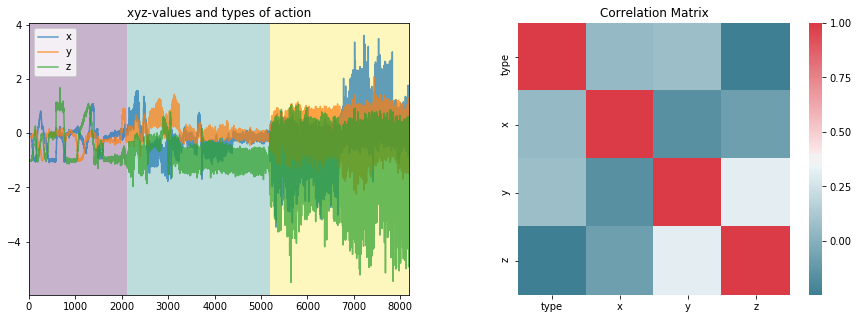

In [3]:
_, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

axs[0].set_title("xyz-values and types of action")
dataset.drop(columns='type').plot(ax=axs[0], alpha=0.7)
axs[0].pcolorfast(axs[0].get_xlim(), axs[0].get_ylim(),
              dataset['type'].values[np.newaxis],
              alpha=0.3)

axs[1].set_title("Correlation Matrix")
corr = dataset.corr()
_ = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axs[1])

## Prepare the Data for Model Training and Evaluation

In [4]:
# %load util.py
def series_to_supervised(df, n_in=1, n_out=1, output_columns=[], dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        df: Sequence of observations as a DataFrame.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        output_columns: list of column names to preserve for the output
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        data and labels of series framed for supervised learning.
    """
    column_names = list(df.columns)
    if output_columns != [] and not all(x in column_names for x in output_columns):
        raise Exception('Invalid output_columns %s for columns %s' % (output_columns, column_names))
    
    output_column_names = output_columns if output_columns != [] else column_names.copy()
    output_column_names_to_drop = list(set(column_names) - set(output_column_names))

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        to_append = df.shift(i).drop(columns=output_column_names)
        cols.append(to_append)
        names += [('%s(t-%d)' % (j, i)) for j in output_column_names_to_drop]
        
    # forecast sequence (t, t+1, ... t+n)
    forecast_features = list()
    forecast_features_names = list()
    for i in range(0, n_out):
        to_append = df.shift(-i).drop(columns=output_column_names_to_drop)
        cols.append(to_append)
        if i == 0:
            names += [('%s(t)' % (j)) for j in to_append.columns]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in to_append.columns]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    label_columns = n_out * len(output_columns) 
    labels = agg.iloc[:, -label_columns:]
    data = agg.iloc[:, :-label_columns]
        
    return data, labels

In [5]:
scaled_data = dataset
n_back = 200
n_forward = 1
data, labels = series_to_supervised(dataset, n_back, n_forward, output_columns=['type'])

# One-hot encoding of labels
labels = sklearn.preprocessing.OneHotEncoder(sparse=False, categories='auto').fit_transform(labels)

x_train, x_test, y_train, y_test = model_selection.train_test_split(data.to_numpy(), labels, test_size=0.1, shuffle=True, random_state=123)
print("x_train: %s, y_train: %s, x_test: %s, y_test: %s" % (x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train: (7199, 600), y_train: (7199, 3), x_test: (800, 600), y_test: (800, 3)


## Build and Train the Network
Build a CNN based on Keras using multiple convolutional and pooling layers. Overfitting is tackled by adding a dropout to every convolutional layer. The model predicts the probability for each of the output classes. Using a softmax activation at the output layer, we get an accumulated probability of 1 for all of the classes.

In [6]:
model = keras.models.Sequential()

dropout_rate=0.2

model.add(layers.Reshape((n_back, 3), input_shape=(x_train.shape[1],)))
model.add(layers.Conv1D(5, 10, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Conv1D(5, 10, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(5, 10, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(labels.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 191, 5)            155       
_________________________________________________________________
dropout_1 (Dropout)          (None, 191, 5)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 182, 5)            255       
_________________________________________________________________
dropout_2 (Dropout)          (None, 182, 5)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 5)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 51, 5)             255       
__________

In [7]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 25

early_stop = keras.callbacks.EarlyStopping(monitor='acc', patience=5)
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.........................

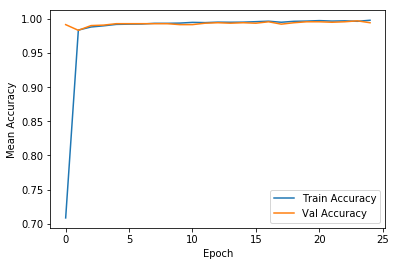

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Accuracy')
plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
plt.plot(hist['epoch'], hist['val_acc'], label = 'Val Accuracy')
plt.legend()
plt.show()

## Predict the Test Data

In [9]:
yhat = model.predict(x_test, verbose=1)

800/800 [==============================] - 1s 1ms/step


## Plot Test Accuracy and Confusion Matrix

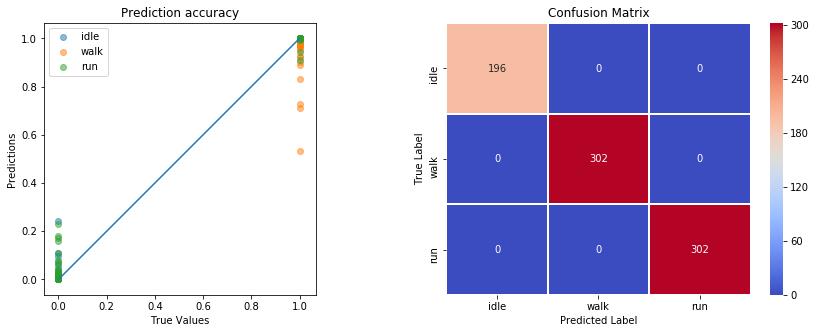

<Figure size 432x288 with 0 Axes>

In [10]:
LABELS = ["idle", "walk", "run"]

_, axs = plt.subplots(1,2, figsize=(15, 5))
axs = axs.ravel()

# Prediction accuracy
for i in range(y_test.shape[1]):
    axs[0].scatter(y_test[:,i], yhat[:,i], label='%s' % LABELS[i], alpha=.5)
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')
axs[0].set_title('Prediction accuracy')
axs[0].legend()
axs[0].axis('square')
axs[0].plot([0, 1], [0, 1])

# confusion matrix
matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yhat, axis=1))
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap="coolwarm",
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt="d",
            ax=axs[1])
axs[1].set_title("Confusion Matrix")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")
plt.show()

## Export for iOS CoreML
Export the trained model so that it can be used with iOS CoreML.

In [11]:
import coremltools
model.name = "MotionClassifier"
coreml_model = coremltools.converters.keras.convert(model, output_names=['prediction'], class_labels=LABELS)
coreml_model.save('data/motion-classifier.mlmodel')

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x1a3cfbbf98>
1 : reshape_1, <keras.layers.core.Reshape object at 0x1a3cf87908>
2 : reshape_1_permute_conv1d_1, <keras.layers.core.Permute object at 0x1a47a847f0>
3 : conv1d_1, <keras.layers.convolutional.Conv1D object at 0x1a3cfbbba8>
4 : conv1d_1__activation__, <keras.layers.core.Activation object at 0x1a47a84e48>
5 : conv1d_2, <keras.layers.convolutional.Conv1D object at 0x1a3cc083c8>
6 : conv1d_2__activation__, <keras.layers.core.Activation object at 0x1a47f7fa20>
7 : max_pooling1d_1, <keras.layers.pooling.MaxPooling1D object at 0x1a3cc34160>
8 : conv1d_3, <keras.layers.convolutional.Conv1D object at 0x1a3cc6afd0>
9 : conv1d_3__activation__, <keras.layers.core.Activation object at 0x1a47f7fb38>
10 : global_average_pooling1d_1, <keras.layers.pooling.GlobalAveragePooling1D object at 0x1a3cc83160>
11 : global_average_pooling1d_1_permute_dense_1, <keras.layers.core.Permute object at 0x1a47a84d30>
12 : dense_1, <keras.l